## Predicting Wine Quality <a id="chapter-1"></a>
##### *Shaheen Gauher, Data Scientist at Microsoft*
#### Problem: Predict wine quality using Multiclass Classification analysis.The data contains quality ratings for a few thousands of wines (1599 red wine samples), along with their physical and chemical properties (11 predictors). We want to use these properties to predict a rating for a wine. The goal is to model wine quality based on physicochemical tests. 
(**data from** https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv )  
***Azure ML experiment*** at https://gallery.cortanaintelligence.com/Experiment/Predict-Wine-Quality-Classification-10 

In [107]:

#download data from
#https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data
data_wine = read.table("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv",
                       header=T,sep=";",na.strings="NA") #1599 12
class(data_wine)  #"data.frame"

#Relabel quality ratings as follows
#3,4,5 as Low
#6 as Med
#7,8 as High

data_wine$qualityV2 = ifelse(data_wine$quality <=5, 'Low','None')
TorF = data_wine$quality == 6
data_wine$qualityV2[TorF] = 'Med'
TorF = data_wine$quality > 6
data_wine$qualityV2[TorF] = 'High'

data_wine$quality = NULL
names(data_wine)[names(data_wine)=='qualityV2'] = 'quality'

#convert data frame to xdf object using rxDataStep() 
pathc     = getwd()
dataclassi_xdf = file.path(pathc,'dataclassi_xdf.xdf') 
data_classi = rxDataStep(inData = data_wine, outFile = dataclassi_xdf ,
                       rowsPerRead=500, overwrite=TRUE, reportProgress=0)
class(data_classi)  # "RxXdfData"


[1] "data.frame"

[1] "RxXdfData"
attr(,"package")
[1] "RevoScaleR"

In [111]:
#make a new column factorQuality from quality col -- make it categorical
rxFactors(inData = data_classi, outFile = data_classi, overwrite = TRUE,
          factorInfo = list(factorQuality = list(varName = "quality")), reportProgress=0)

#can remove the col quality now
ColsToKeep = setdiff(names(data_classi),c('quality'))

data_classi = rxDataStep(inData = data_classi, outFile = 'data_classi_temp.xdf',varsToKeep = ColsToKeep, overwrite = TRUE, reportProgress=0)

### Data Exploration

Data distribution 
Rows Read: 500, Total Rows Processed: 500, Total Chunk Time: 0.001 seconds
Rows Read: 500, Total Rows Processed: 1000, Total Chunk Time: Less than .001 seconds
Rows Read: 500, Total Rows Processed: 1500, Total Chunk Time: Less than .001 seconds
Rows Read: 99, Total Rows Processed: 1599, Total Chunk Time: Less than .001 seconds 
Computation time: 0.005 seconds.


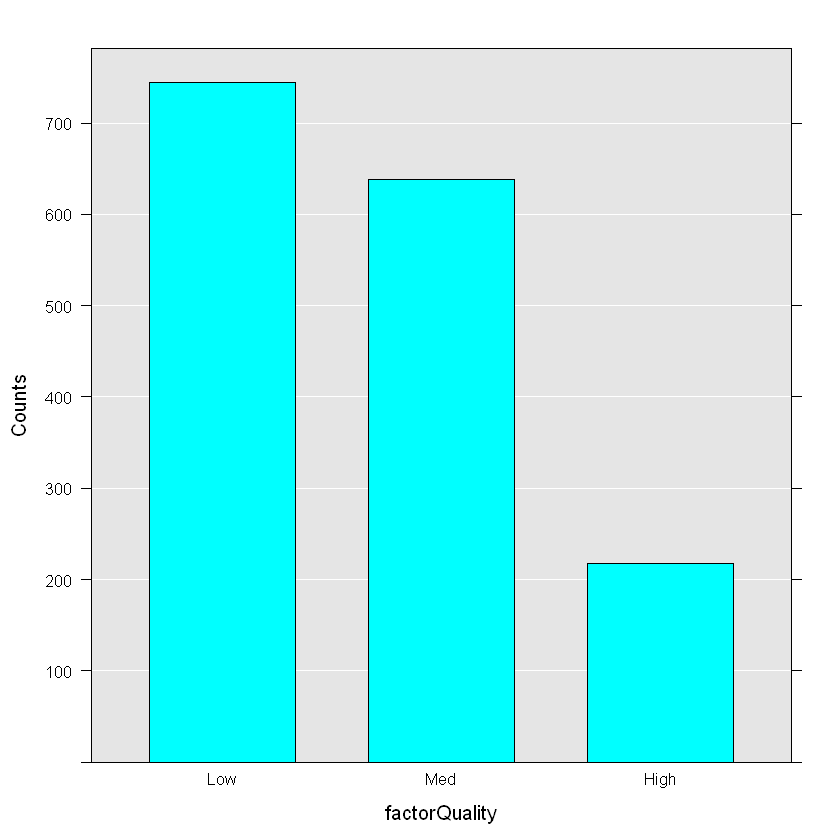

In [113]:
cat("Data distribution \n")
rxHistogram(formula = ~ factorQuality, data = data_classi)

A line plot 
Rows Read: 500, Total Rows Processed: 500, Total Chunk Time: 0.002 seconds
Rows Read: 500, Total Rows Processed: 1000, Total Chunk Time: Less than .001 seconds
Rows Read: 500, Total Rows Processed: 1500, Total Chunk Time: 0.001 seconds
Rows Read: 99, Total Rows Processed: 1599, Total Chunk Time: Less than .001 seconds 


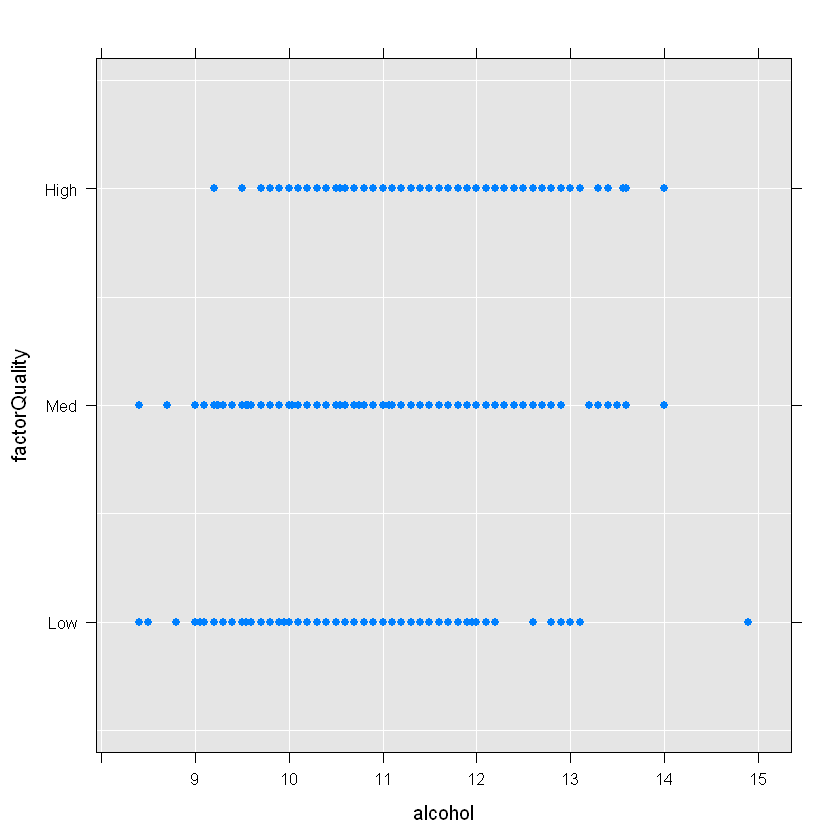

In [115]:
cat("A line plot \n")
rxLinePlot(factorQuality ~ alcohol, type = "p", data = data_classi) 

In [87]:
#rename the label col 'factorQuality' as 'LabelsCol'
names(data_classi)[names(data_classi)=='factorQuality'] = 'LabelsCol'
names(data_classi)

[1] "fixed.acidity"        "volatile.acidity"     "citric.acid"         
 [4] "residual.sugar"       "chlorides"            "free.sulfur.dioxide" 
 [7] "total.sulfur.dioxide" "density"              "pH"                  
[10] "sulphates"            "alcohol"              "LabelsCol"

In [88]:
#use rxDataStep() to create a col called 'splitcol' to use for splitting
rxDataStep(inData=data_classi,outFile=data_classi,transforms=list(splitcol=factor(rbinom(.rxNumRows,1,0.8),labels=c('test','train'))),
           overwrite=T, reportProgress=0)  
names(data_classi)

#split using the col "splitcol" 
#rxSplit() -- Splits an input '.xdf' file or data frame into multiple '.xdf' files or a list of data frames.
listofxdfs = rxSplit(data_classi,outFileBase='data_classi_split',outFileSuffixes=c("Train", "Test"),splitByFactor = "splitcol",
                     overwrite=T, reportProgress=0 )

trainingdata = listofxdfs[[2]]
testdata = listofxdfs[[1]]
dim(trainingdata)
dim(testdata)
dim(data_classi)

[1] "fixed.acidity"        "volatile.acidity"     "citric.acid"         
 [4] "residual.sugar"       "chlorides"            "free.sulfur.dioxide" 
 [7] "total.sulfur.dioxide" "density"              "pH"                  
[10] "sulphates"            "alcohol"              "LabelsCol"           
[13] "splitcol"

[1] 1250   13

[1] 349  13

[1] 1599   13

In [89]:
#collect names of columns (features) to be used for modelling
allfeatures = setdiff(names(data_classi),c('LabelsCol','splitcol'))

#create formula for modelling
formula = as.formula(paste('LabelsCol',paste(allfeatures,collapse=' + '),sep=' ~ '))  
formula


LabelsCol ~ fixed.acidity + volatile.acidity + citric.acid + 
    residual.sugar + chlorides + free.sulfur.dioxide + total.sulfur.dioxide + 
    density + pH + sulphates + alcohol

In [90]:
Algorithms <- c("Decision Forest Classification",
                "Boosted Decision Tree Classification",
                "Decision Tree Classification")


In [91]:
################################################################################
## Decision forest modeling
################################################################################
#Decision Forest
#using rxDForest() to build ML model
DForest_model <- rxDForest(formula = formula, 
                           data = trainingdata, 
                           seed = 10, 
                           cp = 0.01, 
                           nTree = 50, 
                           mTry = 2,                   
                           overwrite = TRUE, 
                           reportProgress = 0)
DForest_model
class(DForest_model) #"rxDForest" 



Call:
rxDForest(formula = formula, data = trainingdata, overwrite = TRUE, 
    cp = 0.01, nTree = 50, mTry = 2, seed = 10, reportProgress = 0)


             Type of decision forest: class 
                     Number of trees: 50 
No. of variables tried at each split: 2 

         OOB estimate of error rate: 38.16%
Confusion matrix:
         Predicted
LabelsCol Low Med High class.error
     Low  439 144    1   0.2482877
     Med  183 304    7   0.3846154
     High  11 131   30   0.8255814

[1] "rxDForest"

In [92]:
################################################################################
## Boosted tree modeling
################################################################################
BoostedTree_model = rxBTrees(formula = formula,
                          data = trainingdata,
                          learningRate = 0.2,
                          minSplit = 10,
                          minBucket = 10,
                          nTree = 100,
                          lossFunction = "multinomial",
                          reportProgress = 0)
BoostedTree_model
class(BoostedTree_model)



Call:
rxBTrees(formula = formula, data = trainingdata, minSplit = 10, 
    minBucket = 10, nTree = 100, lossFunction = "multinomial", 
    learningRate = 0.2, reportProgress = 0)


      Loss function of boosted trees: multinomial 
       Number of boosting iterations: 100 
No. of variables tried at each split: 3 

            OOB estimate of deviance: 0.6543003 

[1] "rxBTrees"  "rxDForest"

In [93]:
################################################################################
## Decision Tree Modelling
################################################################################

#rxDTree
DTree_model = rxDTree(formula = formula,
                          data = trainingdata,
                          minSplit = 10,
                          minBucket = 10,
                          nTree = 100,
                          reportProgress = 0)
DTree_model
class(DTree_model)



Call:
rxDTree(formula = formula, data = trainingdata, minSplit = 10, 
    minBucket = 10, reportProgress = 0, nTree = 100)


             Type of decision forest: class 
                     Number of trees: 100 
No. of variables tried at each split: 0 


[1] "rxDForest"

[1] "rxDForest"

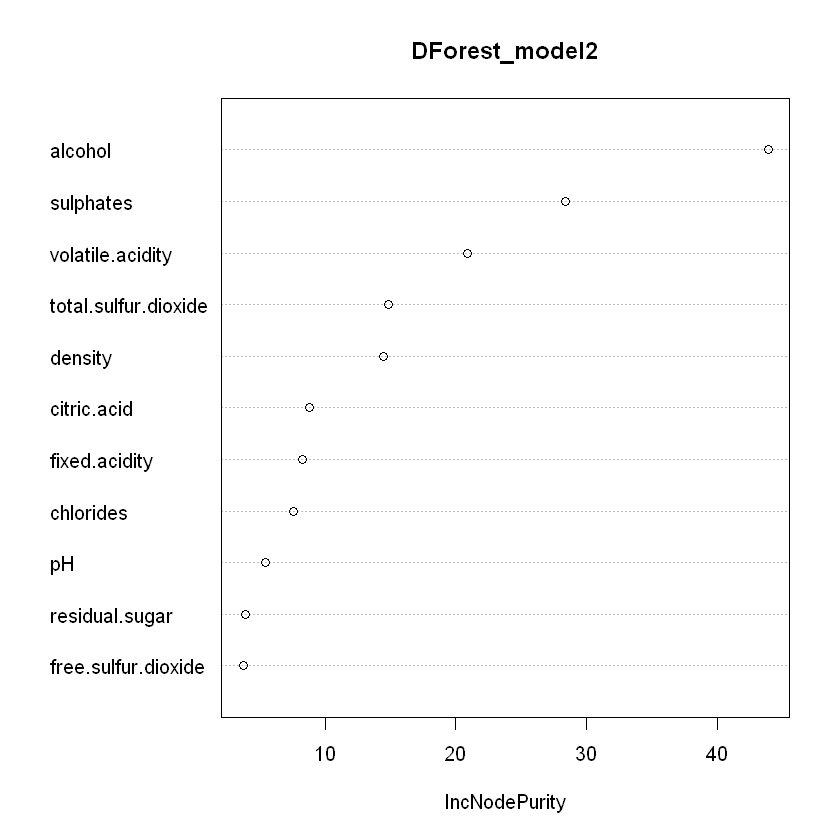

In [106]:
#For feature importance plot we must have importance = TRUE
DForest_model2 <- rxDForest(formula = formula, 
                           data = trainingdata, 
                           seed = 10, 
                           cp = 0.01, 
                           nTree = 50, 
                           mTry = 2,   
                           importance = TRUE,
                           overwrite = TRUE, 
                           reportProgress = 0)
class(DForest_model2) #"rxDForest" 

#Feature Importance plot
rxVarImpPlot(DForest_model2)

In [96]:
#Function to compute accuracy of the trained model on the given data
computeaccuracy <- function(ML_model,scoredata){
  if(file.exists("modelout_xdf.xdf") ) {  file.remove("modelout_xdf.xdf") }
  modelout_xdf = RxXdfData("modelout_xdf.xdf") #initialise xdf object 
  rxPredict(ML_model, data = scoredata, outData = modelout_xdf, overwrite = TRUE,
            writeModelVars = TRUE, reportProgress = 0)
  #head(modelout_xdf)  #contains the actual and predicted cols
  
  #get the columns "LabelsCol_Pred" and "LabelsCol" from modelout_xdf


  mytemp_xdf = RxXdfData("mytemp_xdf.xdf") #initialise an xdf object 
  results_model = rxDataStep(inData = modelout_xdf, outFile = mytemp_xdf,varsToKeep = c('LabelsCol_Pred','LabelsCol'),
                             overwrite = TRUE, reportProgress = 0 )

  cm = rxCrossTabs(~LabelsCol_Pred:LabelsCol,results_model,returnXtabs = T, reportProgress=0) #create a confusion matrix
  cm
  accuracy = sum(diag(cm)) / sum(cm)
  accuracy
    
  #cat('The model produced an accuracy = ',accuracy,'\n')
  return(accuracy)
}
# to invoke function:
# computeaccuracy(ML_model,testdata)
# computeaccuracy(ML_model,trainingdata)
# where
# ML_model = DForest_model  
# ML_model = BoostedTree_model
# ML_model = DTree_model

In [97]:
#====================================================

ML_model = DForest_model

cat('For Decision Forest: accuracy = ',computeaccuracy(ML_model,trainingdata),'\n')
cat('For Decision Forest: accuracy on test data = ',computeaccuracy(ML_model,testdata),'\n')
#====================================================
ML_model = BoostedTree_model

cat('For Boosted tree: accuracy = ',computeaccuracy(ML_model,trainingdata),'\n')
cat('For Boosted tree: accuracy on test data = ',computeaccuracy(ML_model,testdata),'\n')
#====================================================
ML_model = DTree_model

cat('For Decision Tree: accuracy = ',computeaccuracy(ML_model,trainingdata),'\n')
cat('For Decision Tree: accuracy on test data = ',computeaccuracy(ML_model,testdata),'\n')


For Decision Forest: accuracy =  0.6712 
For Decision Forest: accuracy on test data =  0.6418338 
For Boosted tree: accuracy =  0.7216 
For Boosted tree: accuracy on test data =  0.6561605 
For Decision Tree: accuracy =  0.7624 
For Decision Tree: accuracy on test data =  0.5644699 
